# Options sur devises

In [173]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Simulation de trajectoires sous la probabilité historique

In [174]:
class BlackScholes:
    """
    Simulates asset price paths under the Black-Scholes model.

    Parameters
    ----------
    mu : float
        The drift (expected return) of the asset.
    sigma : float
        The volatility of the asset.
    """

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def generate(self, x, T, N, n):
        """
        Generate simulated price paths using the discrete-time Black-Scholes model.

        Parameters
        ----------
        x : float
            Initial asset price.
        T : float
            Maturity (in years).
        N : int
            Number of time steps.
        n : int
            Number of simulated paths.

        Returns
        -------
        S : ndarray of shape (n, N)
            Simulated asset price trajectories.
        """
        S = np.zeros((n, N))
        S[:, 0] = x
        dt = T / N

        for i in range(1, N):
            S[:, i] = S[:, i-1] + S[:, i-1] * (
                self.mu * dt + self.sigma * np.sqrt(dt) * np.random.randn(n)
            )

        return S

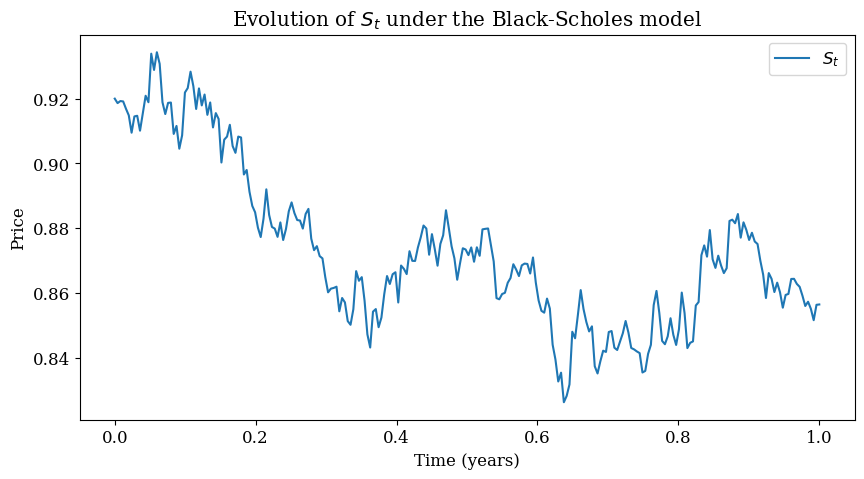

In [175]:
# Parameters
S0 = 0.92         # Initial exchange rate (e.g., 1 USD = 0.92 EUR)
sigma = 0.10      # Volatility
mu = -0.04         # Real drift (not used for risk-neutral pricing)
r0 = 0.03         # Domestic interest rate (France, in EUR)
r1 = 0.07         # Foreign interest rate (USA, in USD)
T = 1             # Maturity in years
N = 252           # Number of time steps (trading days)
dt = T / N        # Time step
n = 1             # Number of simulated paths

# Create the Black-Scholes model
model = BlackScholes(mu, sigma)

# Simulate the trajectories
trajectory = model.generate(S0, T, N, n)

# Time grid
time_grid = np.linspace(0, T, N)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_grid, trajectory[0], label='$S_t$')
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.title("Evolution of $S_t$ under the Black-Scholes model")
plt.legend()
plt.savefig("pics/cours-dollar.png")
plt.show()

## Prix et Delta

In [176]:
def call_prices(trajectories, T, N, K, r0, r1, sigma):
    """
    Computes the price of a European call option at each time step for multiple simulated asset paths
    under the Black-Scholes model.

    Parameters
    ----------
    trajectories : ndarray of shape (n, N)
        Simulated asset price trajectories, where `n` is the number of paths and `N` is the number of time steps.
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    K : float
        Strike price of the option.
    r : float
        Risk-free interest rate.
    sigma : float
        Volatility of the underlying asset.

    Returns
    -------
    p : ndarray of shape (n, N)
        Theoretical European call option prices at each time step and for each trajectory.
    """
    n = trajectories.shape[0]
    dt = T / N
    time_grid = np.linspace(0, T, N)
    p = np.zeros((n, N))

    for i in range(N - 1):
        tau = T - time_grid[i]
        S_t = trajectories[:, i]

        d1_val = (np.log(S_t / K) + (r0-r1 + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2_val = d1_val - sigma * np.sqrt(tau)

        p[:, i] = np.exp(-r1 * tau) * S_t * norm.cdf(d1_val) - K * np.exp(-r0 * tau) * norm.cdf(d2_val)

    # Final value at maturity: option payoff
    p[:, -1] = np.maximum(trajectories[:, -1] - K, 0)

    return p

In [177]:
def put_prices(trajectories, T, N, K, r0, r1, sigma):
    n = trajectories.shape[0]
    p = np.zeros((n, N))
    p_call = call_prices(trajectories, T, N, K, r0, r1, sigma)
    for i in range(N-1):
        S_t = trajectories[:, i]
        tau = T-i*T/N
        p[:, i] = p_call[:, i] - S_t * np.exp(-r1*tau)
        p[:, i] +=  K*np.exp(-r0*tau)
        
    # Final value at maturity: option payoff
    p[:, -1] = np.maximum(K-trajectories[:, -1], 0)
    return p

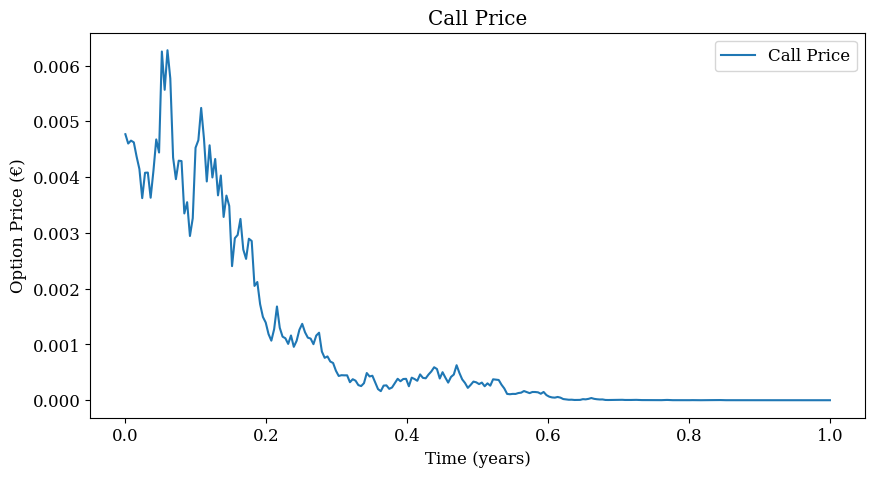

In [178]:
# Option pricing
K = 1  # Strike price
prices_call = call_prices(trajectory, T, N, K, r0, r1, sigma)[0, :]

# Plot option price over time
plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices_call, label='Call Price')
plt.xlabel("Time (years)")
plt.ylabel("Option Price (€)")
plt.title("Call Price")
plt.legend()
plt.show()

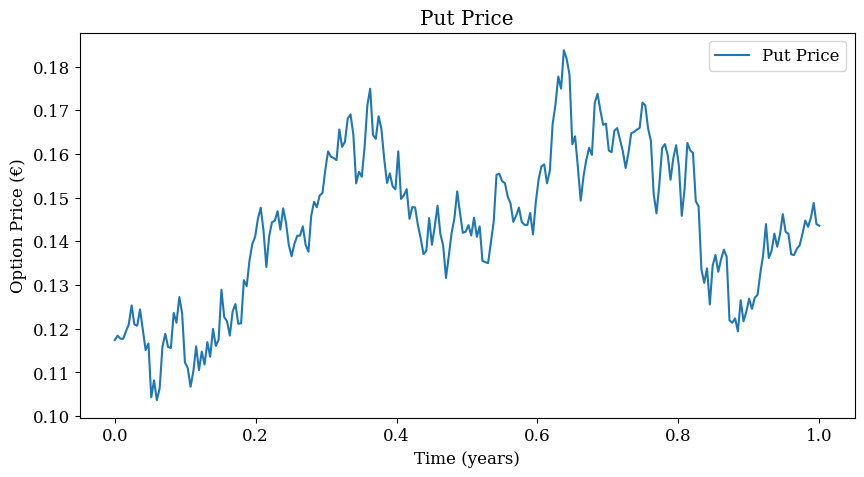

In [179]:
# Put pricing
prices_put = put_prices(trajectory, T, N, K, r0, r1, sigma)[0, :]

# Plot option price over time
plt.figure(figsize=(10, 5))
plt.plot(time_grid, prices_put, label='Put Price')
plt.xlabel("Time (years)")
plt.ylabel("Option Price (€)")
plt.title("Put Price")
plt.legend()
plt.show()

# Couverture

In [180]:
def d_plus(tau, x, T, K, r0, r1, sigma):
    d = (x*np.exp(-r1*tau))/(K*np.exp(-r0*tau))
    d = np.log(d) / (sigma * np.sqrt(tau))
    d += sigma * np.sqrt(tau) / 2
    return d

In [181]:
def h_call(i, S, T, N, K, r0, r1, sigma):
    t = i*T/N
    tau = T - t
    dplus = d_plus(tau, S, T, K, r0, r1, sigma)
    return norm.cdf(dplus) * np.exp(-r1 * tau)

def h_put(i, S, T, N, K, r0, r1, sigma):
    t = i*T/N
    tau = T - t
    dplus = d_plus(tau, S, T, K, r0, r1, sigma)
    return -norm.cdf(-dplus) * np.exp(-r1 * tau)

In [182]:
def hedging(trajectories, C0, T, N, K, r0, r1, sigma, f):
    n = trajectories.shape[0]
    dt = T / N

    H0 = np.zeros((n, N))  # Cash
    H = np.zeros((n, N))   # Delta (asset holding)
    V = np.zeros((n, N))   # Total value of the portfolio

    time_grid = np.linspace(0, T, N)
    tau_grid = T - time_grid
    tau_grid[N - 1] += 1e-4  # Avoid division by zero at maturity

    # Initial hedge at time t = 0
    tau = tau_grid[0]
    d1_0 = d_plus(tau, trajectories[:, 0], T, K, r0, r1, sigma)
    H[:, 0] = norm.cdf(d1_0) * np.exp(-r1*T)
    H0[:, 0] = C0 - H[:, 0] * trajectories[:, 0]
    V[:, 0] = H[:, 0] * trajectories[:, 0] + H0[:, 0]

    for i in range(1, N):
        t = i * dt
        S_i = trajectories[:, i]

        H0[:, i] = H0[:, i - 1] * np.exp(r0 * dt)
        h = H[:, i - 1] * np.exp(r1 * dt)

        # Utilise la nouvelle fonction f pour calculer H
        H[:, i] = f(i, S_i, T, N, K, r0, r1, sigma)

        H0[:, i] -= (H[:, i] - h) * S_i
        V[:, i] = H[:, i] * S_i + H0[:, i]

    return H0, H, V

## Call

In [183]:
(H0, H, val) = hedging(trajectory, prices_call[0], T, N, K, r0, r1, sigma, h_call)

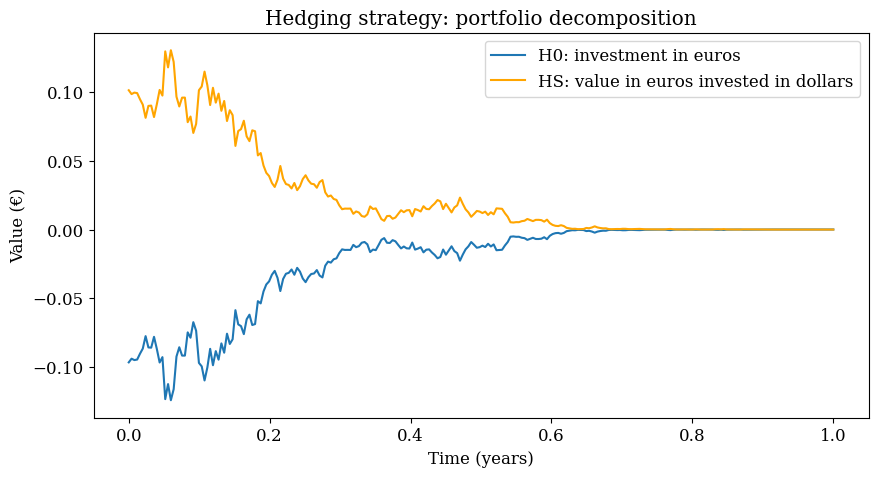

In [184]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, H0[0], label='H0: investment in euros')
plt.plot(time_grid, H[0] * trajectory[0], label='HS: value in euros invested in dollars', color='orange')
plt.xlabel("Time (years)")
plt.ylabel("Value (€)")
plt.title("Hedging strategy: portfolio decomposition")
plt.legend()
plt.savefig("pics/positions-couverture-call.png")
plt.show()

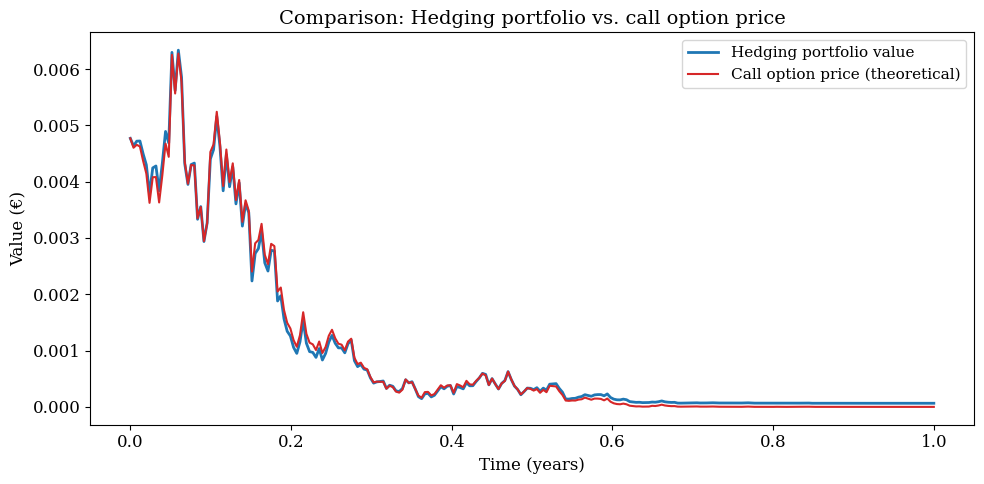

In [185]:
# Plot comparison: hedging portfolio vs. call option price
plt.figure(figsize=(10, 5))

# Main plot: hedging portfolio value
plt.plot(time_grid, val[0], label='Hedging portfolio value', color='#1f77b4', linewidth=2)

# Theoretical call option price (solid line)
plt.plot(time_grid, prices_call, label='Call option price (theoretical)',
         color='#d62728', linewidth=1.5)

# Titles and axes
plt.title("Comparison: Hedging portfolio vs. call option price", fontsize=14)
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Value (€)", fontsize=12)

# Legend and layout
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("pics/valeur-couverture-call.png")
plt.show()

## Put

In [186]:
(H0, H, val) = hedging(trajectory, prices_put[0], T, N, K, r0, r1, sigma, h_put)

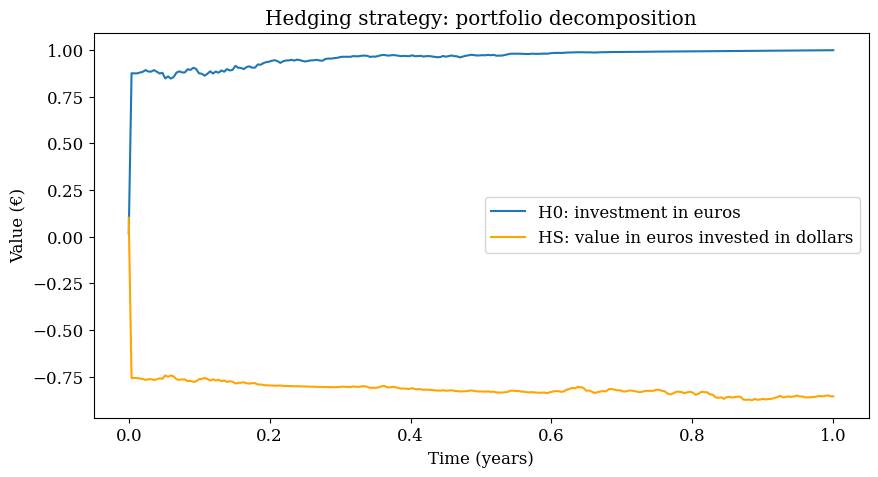

In [187]:
time_grid = np.linspace(0, T, N)

plt.figure(figsize=(10, 5))
plt.plot(time_grid, H0[0], label='H0: investment in euros')
plt.plot(time_grid, H[0] * trajectory[0], label='HS: value in euros invested in dollars', color='orange')
plt.xlabel("Time (years)")
plt.ylabel("Value (€)")
plt.title("Hedging strategy: portfolio decomposition")
plt.legend()
plt.savefig("pics/positions-couverture-put.png")
plt.show()

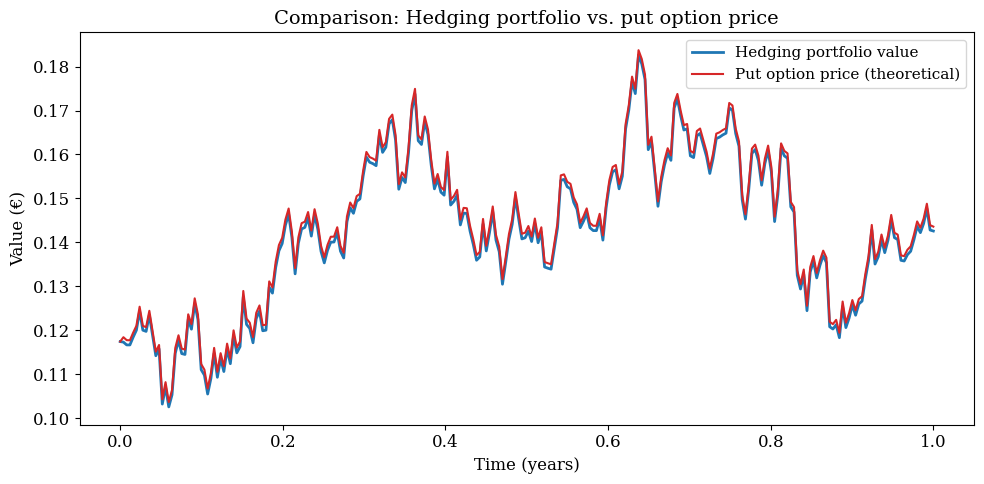

In [188]:
# Plot comparison: hedging portfolio vs. put option price
plt.figure(figsize=(10, 5))

# Main plot: hedging portfolio value
plt.plot(time_grid, val[0], label='Hedging portfolio value', color='#1f77b4', linewidth=2)

# Theoretical put option price (solid line)
plt.plot(time_grid, prices_put, label='Put option price (theoretical)',
         color='#d62728', linewidth=1.5)

# Titles and axes
plt.title("Comparison: Hedging portfolio vs. put option price", fontsize=14)
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Value (€)", fontsize=12)

# Legend and layout
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("pics/valeur-couverture-put.png")
plt.show()

## Exercice de couverture

## Call

In [189]:
def risk(T, N, n_simul, mu, sigma, x, K, r0, r1, h):
    """
    Computes the hedging error for a European call option using a delta hedging strategy
    under the Black-Scholes model.

    Parameters
    ----------
    T : float
        Maturity of the option (in years).
    N : int
        Number of time steps.
    n_simul : int
        Number of simulated asset price trajectories.
    mu : float
        Drift (expected return) of the asset.
    sigma : float
        Volatility of the asset.
    x : float
        Initial asset price.
    K : float
        Strike price of the European call option.
    r : float
        Risk-free interest rate.

    Returns
    -------
    R : ndarray of shape (n_simul,)
        Hedging error at maturity for each simulated path, defined as:
        portfolio value - option payoff.
    """
    model = BlackScholes(mu, sigma)

    # Simulate asset price trajectories
    trajectories = model.generate(x, T, N, n_simul)

    # Compute the theoretical call price along each trajectory
    C_all = call_prices(trajectories, T, N, K, r0, r1, sigma)

    # Get the initial option price for each path
    C0 = C_all[:, 0]

    # Perform delta hedging for each path
    H0, H, V = hedging(trajectories, C0, T, N, K, r0, r1, sigma, h)

    # Compute payoff of the European call at maturity
    payoff = np.maximum(trajectories[:, -1]-K, 0)

    # Hedging error: difference between hedged portfolio and actual payoff
    R = V[:, -1] - payoff

    return R

In [190]:
n_simul = 100000
R = risk(T, N, n_simul, mu, sigma, S0, K, r0, r1, h)

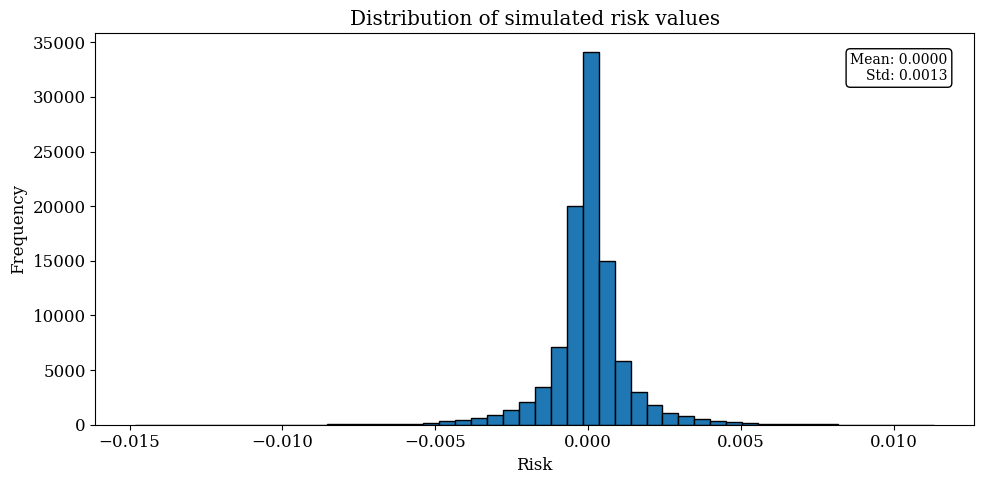

In [191]:
# Calcul de la moyenne et de la variance
mean_r = np.mean(R)
var_r = np.std(R)

plt.figure(figsize=(10, 5))
plt.hist(R, bins=50, edgecolor='black')
plt.title("Distribution of simulated risk values")
plt.xlabel("Risk")
plt.ylabel("Frequency")

# Annotation de la moyenne et de la variance
textstr = f"Mean: {mean_r:.4f}\nStd: {var_r:.4f}"
plt.annotate(textstr, xy=(0.97, 0.95), xycoords='axes fraction',
             fontsize=10, ha='right', va='top',
             bbox=dict(boxstyle="round", fc="white", ec="black"))

plt.tight_layout()
plt.savefig("pics/risk-distribution.png")
plt.show()

# Erreur moyenne quadratique vs pas de temps

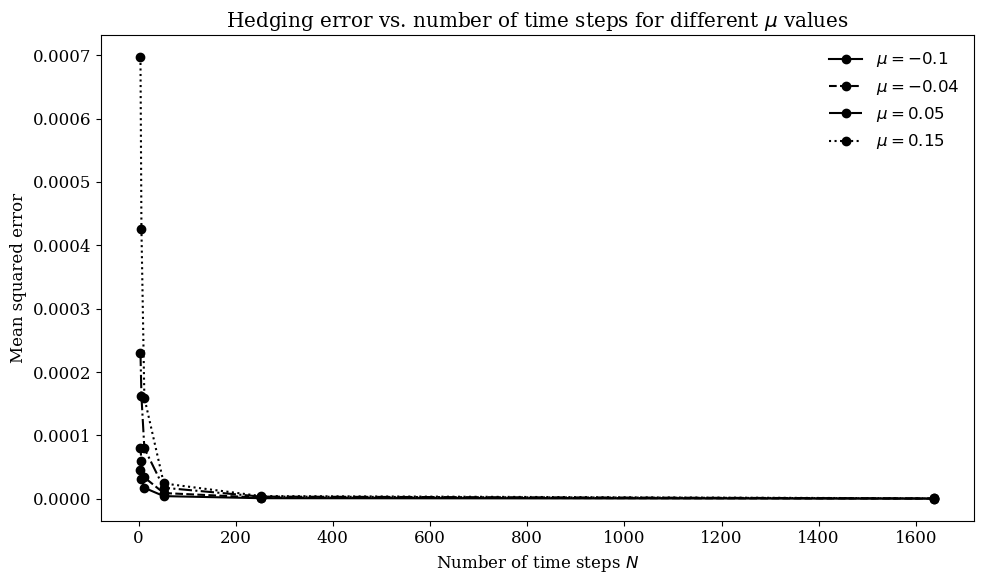

In [192]:
# Parameters
N_values = [4, 6, 12, 52, 252, 1638]
n_simul = 10000
mu_values = [-0.1, -0.04, 0.05, 0.15]

# Même couleur, styles de ligne différents
line_styles = ['-', '--', '-.', ':']
base_color = 'black'

plt.figure(figsize=(10, 6))
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12
})

# Tracer chaque courbe avec un style de ligne différent
for mu, style in zip(mu_values, line_styles):
    R_squared_means = np.zeros(len(N_values))
    for i, N in enumerate(N_values):
        R_simul = risk(T, N, n_simul, mu, sigma, S0, K, r0, r1, h)
        R_squared_means[i] = np.mean(R_simul**2)

    plt.plot(N_values, R_squared_means, linestyle=style, color=base_color,
             marker='o', label=f"$\\mu = {mu}$")

# Axes et titres
plt.xlabel("Number of time steps $N$")
plt.ylabel("Mean squared error")
plt.title("Hedging error vs. number of time steps for different $\\mu$ values")

# Légende propre
plt.legend(frameon=False)

# Fignolage
plt.tight_layout()
plt.savefig("pics/hedging_error_line_styles.png", dpi=300)
plt.show()

# Défaut de couverture

In [193]:
def payoff_call(x, K):
    return np.maximum(0, x-K)

def payoff_put(x, K):
    return np.maximum(0, K-x)

## Call

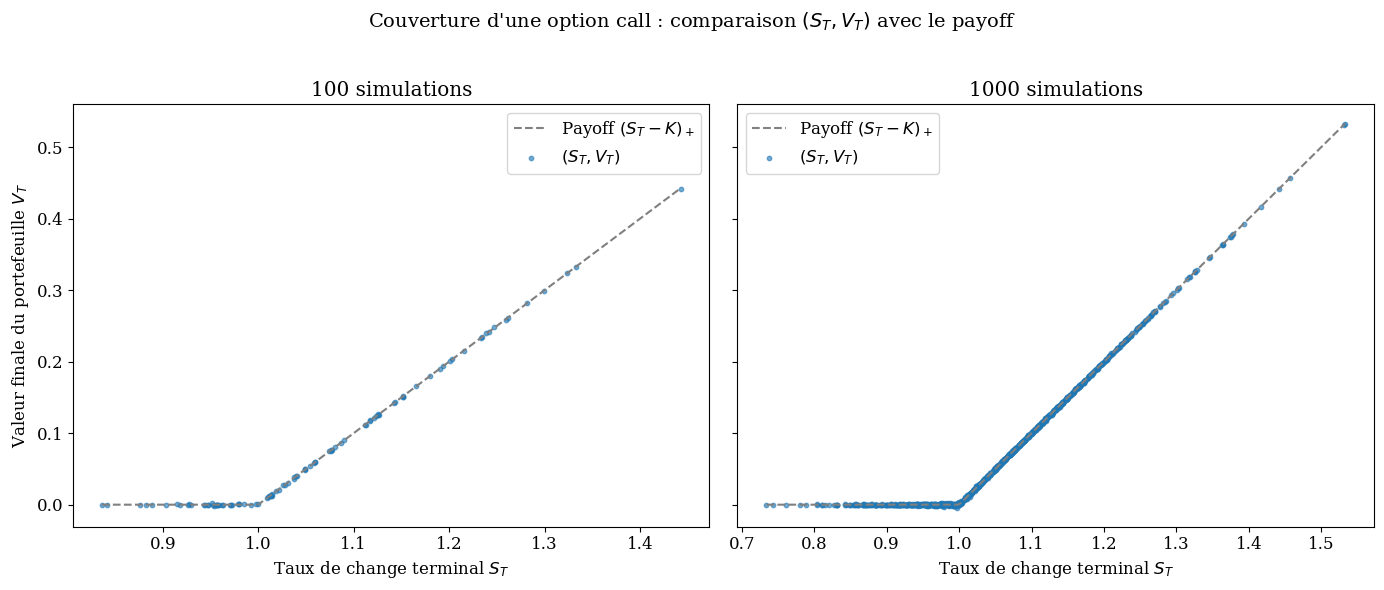

In [194]:
# Simulation settings
n_points_list = [100, 1000]
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, n_points in enumerate(n_points_list):
    # Simulate trajectories
    model = BlackScholes(mu, sigma)
    trajectories = model.generate(S0, T, N, n_points)
    
    # Apply hedging strategy
    (H0, H, val) = hedging(trajectories, prices_call[0], T, N, K, r0, r1, sigma, h_call)

    # Terminal values
    S_T = trajectories[:, -1]
    V_T = val[:, -1]

    # Theoretical payoff
    x_vals = np.linspace(min(S_T), max(S_T), 200)
    payoff = payoff_call(x_vals, K)

    # Plot payoff and hedging results
    axs[idx].plot(x_vals, payoff, color='gray', linestyle='--', label='Payoff $(S_T - K)_+$')
    axs[idx].scatter(S_T, V_T, alpha=0.6, s=10, label='$(S_T, V_T)$')

    # Titles and labels
    axs[idx].set_title(f"{n_points} simulations")
    axs[idx].set_xlabel("Taux de change terminal $S_T$")
    if idx == 0:
        axs[idx].set_ylabel("Valeur finale du portefeuille $V_T$")
    axs[idx].legend()

# Final layout and save
plt.suptitle("Couverture d'une option call : comparaison $(S_T, V_T)$ avec le payoff", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("pics/couverture_comparaison_100_vs_1000-call.png", dpi=300)
plt.show()




## Put

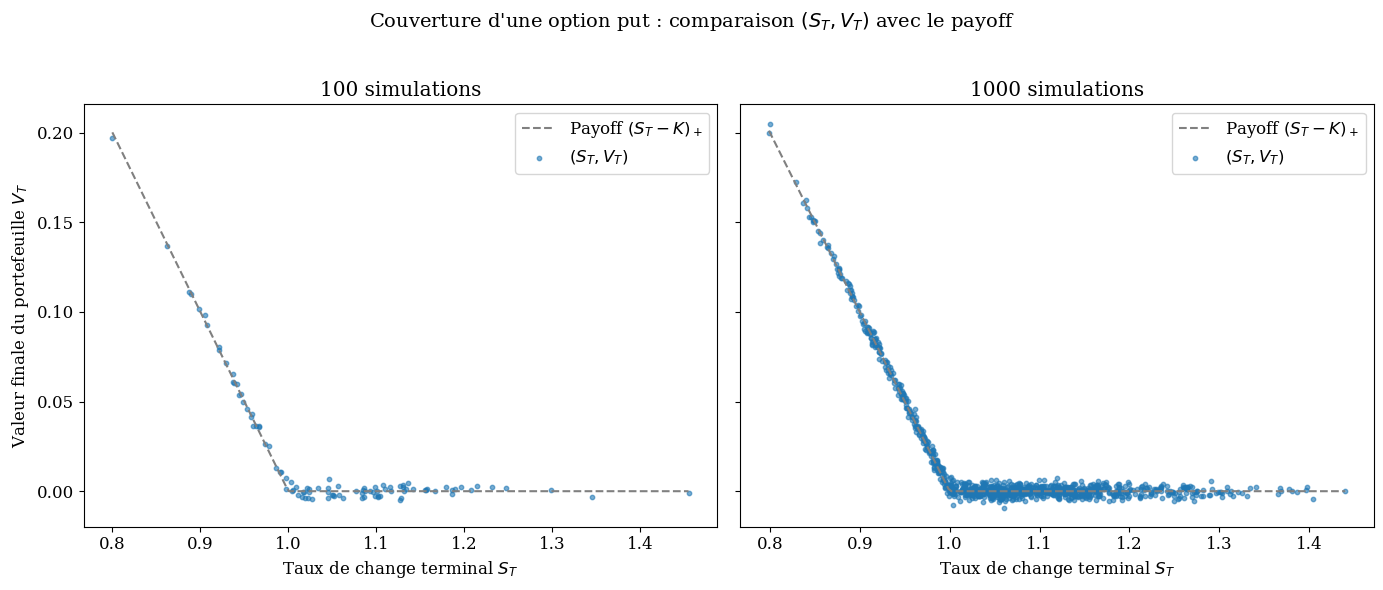

In [195]:
# Simulation settings
n_points_list = [100, 1000]
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for idx, n_points in enumerate(n_points_list):
    # Simulate trajectories
    model = BlackScholes(mu, sigma)
    trajectories = model.generate(S0, T, N, n_points)
    
    # Apply hedging strategy
    (H0, H, val) = hedging(trajectories, prices_put[0], T, N, K, r0, r1, sigma, h_put)

    # Terminal values
    S_T = trajectories[:, -1]
    V_T = val[:, -1]

    # Theoretical payoff
    x_vals = np.linspace(min(S_T), max(S_T), 200)
    payoff = payoff_put(x_vals, K)

    # Plot payoff and hedging results
    axs[idx].plot(x_vals, payoff, color='gray', linestyle='--', label='Payoff $(S_T - K)_+$')
    axs[idx].scatter(S_T, V_T, alpha=0.6, s=10, label='$(S_T, V_T)$')

    # Titles and labels
    axs[idx].set_title(f"{n_points} simulations")
    axs[idx].set_xlabel("Taux de change terminal $S_T$")
    if idx == 0:
        axs[idx].set_ylabel("Valeur finale du portefeuille $V_T$")
    axs[idx].legend()

# Final layout and save
plt.suptitle("Couverture d'une option put : comparaison $(S_T, V_T)$ avec le payoff", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("pics/couverture_comparaison_100_vs_1000-put.png", dpi=300)
plt.show()